In [1]:
import fiona
from fiona import crs as fionacrs
from shapely.geometry import shape
import rasterio
from src.imagery import Collection
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.fill import fillnodata
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling, transform_geom
from rasterio import features
from rasterio.features import geometry_mask, rasterize
import glob
import os
import numpy as np

In [3]:
def get_goemetry_from_feature(collection):
    features = next(iter(collection))
    return [
        shape(feature.get('geometry')) 
        for feature in iter(collection)
    ]

In [4]:
def analyze_feature(collection):
    print('**collection inspection**')
    print(f'driver --> {collection.driver}')
    print(f'crs --> {collection.crs}')
    print(f'crs --> {fionacrs.to_string(collection.crs)}')
    print(f'bounds --> {collection.bounds}')
    print(f'schema --> {collection.schema}')
    
    print('\n\n**shapes inspection**')
    shapes = next(iter(collection))
    print(f'contains --> {shapes.keys()}')
    #print(f'geometry --> {shapes.get("geometry")}')

In [5]:
def analyze_sentinel_image(image):
    show(image)
    print('**image inspection**')
    print(f'size --> {image.height}, {image.width}')
    print(f'driver --> {image.driver}')
    print(f'crs --> {image.crs}')
    print(f'crs --> {fionacrs.to_string(image.crs)}')
    print(f'transform --> {image.get_transform()}')
    print(f'bounds --> {image.bounds}')
    print(f'profile --> {image.profile}')

In [6]:
dirpath = "/home/mluzu/Downloads/gral_lopez_tiles"

In [6]:
def make_mosaic(bands):
    def get_band_stack(band):
        # obtiene la banda de cada tile
        search_criteria = f"*.SAFE/GRANULE/*/IMG_DATA/R20m/*_{band}_*"
        q = os.path.join(dirpath, search_criteria)
        dem_fps = glob.glob(q)
    
        # load source datasets
        src_files_to_band_mosaic = []
        for fp in dem_fps:
            src = rasterio.open(fp)
            src_files_to_band_mosaic.append(src)
        
        return src_files_to_band_mosaic
    
    def make_mosaic_band(files, band):
        # merge de los tiles de la banda
        mosaic, out_trans = merge(files, nodata=0)

        # config destination metadata
        out_meta = files[0].meta.copy()
        out_meta['driver'] = 'GTiff'
        out_meta['height'] = mosaic.shape[1]
        out_meta['width'] = mosaic.shape[2]
        out_meta['transform'] = out_trans
        
        mosaic_path = "/home/mluzu/Downloads/mosaic_{}.tif".format(band)
        
        # write merged mosaic into dataset
        dest = rasterio.open(mosaic_path.format(band), "w", **out_meta)
        dest.write(mosaic)
        dest.close()

        # open mosaic dataset in read mode
        dest = rasterio.open(mosaic_path, "r", **out_meta)
        meta = out_meta
        return dest, out_meta
        
    mosaic_bands = []
    for band in bands:
        band_files = get_band_stack(band)
        mosaic_band, out_meta = make_mosaic_band(band_files, band)
        mosaic_bands.append(mosaic_band)
    return mosaic_bands, out_meta

In [7]:
def mask_tile_clouds(tiles):
    def get_band_cloud_mask(band):
        # obtiene la banda de cada tile
        search_criteria = f"*.SAFE/GRANULE/*/QI_DATA/MSK_CLDPRB_20m.jp2"
        q = os.path.join(dirpath, search_criteria)
        dem_fps = glob.glob(q)
    
        # load source datasets
        src_files_to_band_mosaic = []
        for fp in dem_fps:
            src = rasterio.open(fp)
            src_files_to_band_mosaic.append(src)
        
        return src_files_to_band_mosaic
    
    def make_mosaic_cloud_masks(files, band):
        # merge de los tiles de la banda
        mosaic, out_trans = merge(files)

        # config destination metadata
        out_meta = files[0].meta.copy()
        out_meta['driver'] = 'GTiff'
        out_meta['height'] = mosaic.shape[1]
        out_meta['width'] = mosaic.shape[2]
        out_meta['transform'] = out_trans
        
        mosaic_path = "/home/mluzu/Downloads/mosaic_{}_cmask.tif".format(band)
        
        # write merged mosaic into dataset
        dest = rasterio.open(mosaic_path, "w", **out_meta)
        dest.write(mosaic)
        dest.close()

        # open mosaic dataset in read mode
        dest = rasterio.open(mosaic_path, "r", **out_meta)
        meta = out_meta
        return dest, out_meta
        
    cloud_masks = []
    for band in bands:
        band_files = get_band_cloud_mask(band)
        mosaic_band, out_meta = make_mosaic_cloud_masks(band_files, band)
        cloud_masks.append(mosaic_band)
    
    return cloud_masks, out_meta

In [8]:
collection = fiona.open("shapefile")
# analyze_feature(collection)

In [9]:
bands = ['B02', 'B03', 'B04', 'B05', 'B8A', 'B11', 'B12']
mosaic_bands, out_meta = make_mosaic(bands)
# cloud_masks = make_mosaic_cloud_masks(bands)
# analyze_sentinel_image(mosaic)

In [10]:
shapes = get_goemetry_from_feature(collection)
transformed_shapes = transform_geom(collection.crs, mosaic_bands[0].crs.data, shapes)

In [11]:
def mask_crop(bands_list):
    new_bands_list = []
    for band in bands_list:
        masked_mosaic, out_transf = mask(band, transformed_shapes, crop=True)
        new_bands_list.append(masked_mosaic)
    return new_bands_list

In [12]:
def fill_nodata(bands_list, masks):
    new_bands_list = []
    for i in range(len(bands_list)):
        filled = fillnodata(bands_list[i], masks[i])
        new_bands_list.append(filled)
    return new_bands_list
    

In [13]:
mosaic_bands = mask_crop(mosaic_bands)

In [14]:
out_meta['height'] = mosaic_bands[0].shape[1]
out_meta['width'] = mosaic_bands[0].shape[2]

In [15]:
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 8122, 'height': 5436, 'count': 1, 'crs': CRS.from_epsg(32720), 'transform': Affine(20.0, 0.0, 499980.0,
       0.0, -20.0, 6400000.0)}


- 0 B2 Blue
- 1 B3 Green
- 2 B4 Red
- 3 B5 Vegetation red edge
- 4 B8 Narrow NIR
- 5 B11 SWIR1
- 6 B12 SWIR2

In [16]:
L = 0.5 # vegetation density

def ndvii(bands):
    bands.append(
        bands[4] - bands[2] / bands[4] + bands[2]
    )

def evi(bands):
    bands.append(
         2.5*(bands[4] - bands[2] / bands[4] + bands[2]*6.0 - 7.5*bands[0] + L)
    )
    
def evi2(bands):
    bands.append(
         2.4*(bands[4] - bands[2] / bands[4] - 2.4*bands[2] + 1.0)
    )

def savi(bands):
    bands.append(
         (bands[4] - bands[2] / bands[4] + bands[2] + 0.5) * (1 + L)
    )        

In [17]:
ndvii(mosaic_bands)
evi(mosaic_bands)
evi2(mosaic_bands)
savi(mosaic_bands)

/tmp/ipykernel_27778/271279189.py:5: RuntimeWarning: invalid value encountered in true_divide
  bands[4] - bands[2] / bands[4] + bands[2]
/tmp/ipykernel_27778/271279189.py:10: RuntimeWarning: invalid value encountered in true_divide
  2.5*(bands[4] - bands[2] / bands[4] + bands[2]*6.0 - 7.5*bands[0] + L)
/tmp/ipykernel_27778/271279189.py:15: RuntimeWarning: invalid value encountered in true_divide
  2.4*(bands[4] - bands[2] / bands[4] - 2.4*bands[2] + 1.0)
/tmp/ipykernel_27778/271279189.py:20: RuntimeWarning: invalid value encountered in true_divide
  (bands[4] - bands[2] / bands[4] + bands[2] + 0.5) * (1 + L)


In [18]:
len(mosaic_bands)

11

In [19]:
dataset = np.concatenate(mosaic_bands, axis=0)

In [20]:
dataset.shape

(11, 5436, 8122)

In [28]:
out_meta['count']=dataset.shape[0]

In [31]:
with rasterio.open("/home/mluzu/Downloads/gral_lopez_image.tif", 'w', **out_meta) as dst:
    dst.write(dataset)

In [13]:
def get_croped_tiles(band):
    
    def get_band_stack(band):
        # obtiene la banda de cada tile
        search_criteria = f"*.SAFE/GRANULE/*/IMG_DATA/R20m/*_{band}_*"
        q = os.path.join(dirpath, search_criteria)
        dem_fps = glob.glob(q)
    
        # load source datasets
        src_files_to_band_mosaic = []
        for fp in dem_fps:
            src = rasterio.open(fp)
            src_files_to_band_mosaic.append(src)
        
        return src_files_to_band_mosaic
    
    tiles_list = get_band_stack(band)

    collection = fiona.open("shapefile")
    shapes = get_goemetry_from_feature(collection)
    transformed_shapes = transform_geom(collection.crs, tiles_list[0].crs.data, shapes)
    croped_tiles = []
    for tile in tiles_list:
        croped_tile, out_transf = mask(tile, transformed_shapes, crop=True)
        croped_tiles.append(croped_tile)
    return croped_tiles


In [19]:
bands = ['B02', 'B03', 'B04', 'B05', 'B8A', 'B11', 'B12']
croped_tiles = get_croped_tiles('B8A')

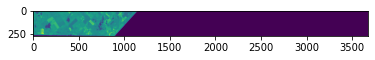

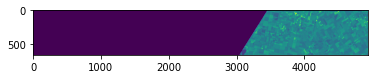

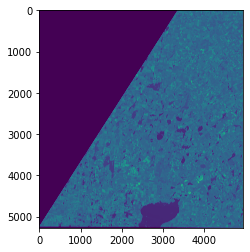

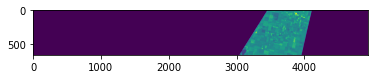

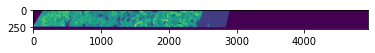

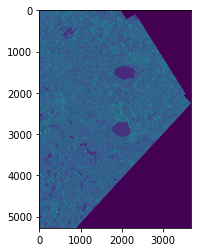

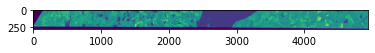

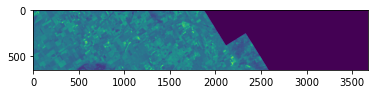

In [20]:
for tile in croped_tiles:
    show(tile)

In [ ]:
 mosaic, out_trans = merge(files, nodata=0)

In [21]:
dest = rasterio.open("/home/mluzu/Downloads/gral_lopez_tiles/S2A_MSIL2A_20220514T141051_N0400_R110_T20HNG_20220514T214513.SAFE/GRANULE/L2A_T20HNG_A036000_20220514T141846/QI_DATA/T20HNG_20220514T141051_PVI.jp2", "r")


In [22]:
img = dest.read()
img.shape

(3, 343, 343)

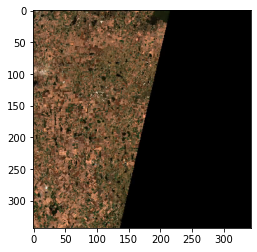

<AxesSubplot:>

In [23]:
show(img)

In [12]:
indx = np.nonzero(img)
indx

(array([0, 0, 0, ..., 0, 0, 0]),
 array([   0,    0,    0, ..., 5489, 5489, 5489]),
 array([  44,   46,   47, ..., 1998, 2001, 2002]))

In [17]:
counts= np.unique(img, return_counts=True)

In [20]:
counts[].shape

(98,)